# Some Constraints For This Talk

- <b>Goal: Provide context for the following talk</b>
- Written from the user-perspective of tools and packages such as 
    - pybind11 
    - scikit-build
    - ctypes
    - cmake
    - ...
- <b>&rightarrow; Feedback would be very much appreciated</b>

- Idea: explain how to provide Python bindings for C/C++ libraries; The git repository contains complete and self-contained examples which should work with minimal external dependencies for reference


    

In [1]:
import os
initial_wd = os.getcwd()

# define some helper functions
%run helpers.py

## First Example: Binding To C Functions using <tt>ctypes</tt>

Let's start with a simple, pure C99, shared library <tt>libqgauss.so</tt>. 
It provides a set of functions for calculating <a href="https://en.wikipedia.org/wiki/Q-Gaussian_distribution">Q-Gaussian</a> distributions in <tt>double</tt> precision

In [2]:
os.chdir( initial_wd )
list_dir_tree( './00_qgauss', allow=["src"] )

00_qgauss/
    CMakeLists.txt
    00_qgauss.kdev4
    src/
        qgauss.h
        qgauss.c
        definitions.h


The library is build using <a href="https://cmake.org/">CMake</a>

```CMake
cmake_minimum_required( VERSION 3.8 )

project( qgauss-c99 VERSION "1.0.0" LANGUAGES C
    DESCRIPTION "minimal c99 library for calculating q-gaussian distributions" )

set( QGAUSS_HEADERS src/definitions.h src/qgauss.h )
set( QGAUSS_SOURCES src/qgauss.c )

add_library( qgauss SHARED ${QGAUSS_HEADERS} ${QGAUSS_SOURCES} )

target_include_directories(
    qgauss PUBLIC $<BUILD_INTERFACE:${CMAKE_SOURCE_DIR}/src> )

set_target_properties( qgauss PROPERTIES
    LINKER_LANGUAGE C
    POSITION_INDEPENDENT_CODE ON
    C_STANDARD 99
    C_STANDARD_REQUIRED ON )
```

In [3]:
# Lets build the library using cmake:
# First, create an out-of-tree build directory if it does not already exist:
os.chdir( initial_wd )
if not os.path.exists( "00_qgauss/build" ):
    os.mkdir( "00_qgauss/build" )

# Move to the build directory and configure the project:
os.chdir( '00_qgauss/build/' ) 
!cmake .. -DCMAKE_BUILD_TYPE=Release -G "Unix Makefiles"
    

-- Configuring done
-- Generating done
-- Build files have been written to: /home/martin/git/pyhep2020-cxx-bindings/00_qgauss/build


In [4]:
# compile the library
!make -j
os.chdir( initial_wd )

[100%] Built target qgauss


Among the API of the library we just compiled is a function to calculate a gaussian distribution
$$\Psi(x) = \frac{1}{\sqrt{2\cdot \pi\cdot \sigma^2}} \cdot exp( -\frac{(x-\mu)^2}{2 \cdot \sigma^2} )$$

```C
/* from 00_qgauss/src/qgauss.h: */
#ifndef QGAUSS_H__
#define QGAUSS_H__

/* Note: definitions in actual headers use lots of macros -> omitted here for clarity */    
/* ... */

extern double qgauss_gauss( double const x, double const sigma, double const mu );
    
/* ... */
``` 

We use the <a href="https://docs.python.org/3/library/ctypes.html"><tt>ctypes</tt></a> library from the python standard library to make this function available to Python:

In [5]:
import ctypes as ct
clib_path = find_dynamic_library( "qgauss", "00_qgauss/build" ) #from helpers.py

clib = ct.CDLL( clib_path )

In [6]:
# create a "handle" for the C-function:
# C-Signature: double qgauss_gauss( double const x, double const sigma, double const mu );

c_gauss_fn = clib.qgauss_gauss
c_gauss_fn.argtypes = [ ct.c_double, ct.c_double, ct.c_double ]
c_gauss_fn.restype = ct.c_double


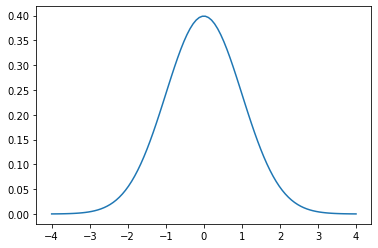

In [7]:
# We can call c_gauss_fn if we wrap the arguments using the correct ctypes - types:
import numpy as np 
from matplotlib import pyplot as plt

mu_arg = ct.c_double( 0.0 )
sigma_arg = ct.c_double( 1.0 )
z = np.linspace(-4.0, 4.0, 100, dtype=np.float64)
plt.plot( z, [ c_gauss_fn( ct.c_double(zz), sigma_arg, mu_arg ) for zz in z ])


### Some Comments on <tt>ctypes</tt>
While <tt>ctypes</tt> has some things going for it, i.e. 
- included in the Python standard library since 2.5 &rightarrow; always available
- some python libraries have interfaces to ctypes to allow easier integration with numpy, scipy, etc. 
- supports functions, custom types (structs, unions), pointers and arrays, ...
- no header or code generator required, works with just the shared library 
- moreover, the library can be compiled without any knowledge about Python &rightarrow; Full control over compile options, toolchains, etc. 

there are some major drawbacks which, depending on the application, can be quite prohibitive:
- Only supports C interfaces
- If the API / signatures change on the C side (incl. alignment, member order, etc.), things can break quite spectacularily &rightarrow; brittle, maintenance intensive code
- Any constraints encoded in the const-ness of the C interfaces gets lost in the mix
- There is no way to code against <tt>ctypes</tt> from native C &rightarrow; all the heavy lifting has to be done in python

&rightarrow; not suitable for "hot-paths", tight-loops, overhead-sensitive function calls, ...

In [8]:
# Re: doing all the heavy lifting in Python .... 

def nice_gauss(z, sigma=1.0, mu=0.0):
    mu_arg = ct.c_double(mu)
    sigma_arg = ct.c_double(sigma)
    if isinstance(z, float):
        return c_gauss_fn(ct.c_double(z), sigma_arg, mu_arg)
    else:
        return np.array(
            [c_gauss_fn(ct.c_double(zz), sigma_arg, mu_arg) for zz in iter(z)],
            dtype=np.float64,
        )

In [9]:
nice_gauss( 0.0 )

0.39894228040143265

In [10]:
nice_gauss( np.linspace( -4.0, 4.0, 16, dtype=np.float64) )

array([1.33830226e-04, 9.80127961e-04, 5.40105618e-03, 2.23945303e-02,
       6.98670761e-02, 1.64010075e-01, 2.89691553e-01, 3.85006875e-01,
       3.85006875e-01, 2.89691553e-01, 1.64010075e-01, 6.98670761e-02,
       2.23945303e-02, 5.40105618e-03, 9.80127961e-04, 1.33830226e-04])

## Moving On: Integration With Build System, OO Python Interface

- So far, we've only looked into a very minimal C library &rightarrow; no particular constraints on the build system
- Exposing all C-Methods to Python &rightarrow; functional Python API

<tt>SixTrackLib</tt> is a complex, mixed C/C++ library with hardware- and platform specific dependencies and constraints &rightarrow; complex build system based on <tt>CMake</tt>. We would like to allow python users to use the familiar installation and setup approach, i.e. 

```Shell
python setup.py build
python setup.py install
``` 

or 

```Shell
pip install .
```

while retaining the ability of users of the C/C++ interface to keep any python dependencies optional and perform the build operation similar to what we have seen in our previous minimal example (i.e. 

```Shell
cmake .. 
make 
echo "make test, make install, etc. ... "
``` 

Additionally, while <tt>SixTrackLib</tt> has a fully supported C-API, for most operations, an object-oriented interface is much nicer to use, especially from Python &rightarrow; How to solve these two issues?

## Introducing ldprofile: A Demo Library for modelling Line Density Functions

In order to keep these examples manageable, we are demonstrating our approach using a small toy library <tt>ldprofile</tt> &rightarrow; all examples should work without CUDA, OpenCL, etc. . 

Like <tt>SixTrackLib</tt>, <tt>ldprofile</tt>
- implements most of its logic in C++11 
- makes use of a templated API which
- has a corresponding C-API specialized for the primarily supported types and
- uses CMake as its build system

<b>Note</b>: While the presented implementation corresponds to features developed for <tt>SixTrackLib</tt>, the actual implementation is not written with performance in mind, just fyi :-)


<img src="99_presentation_data/ldprofile_classes_plots.svg" alt="example line density curves" />

<b>Note:</b> just example plots, y-axis has arbitrary units

Corresponding class hierarchy:

<img src="99_presentation_data/ldprofile_classes.svg" alt="class hierarchy" />

# scikit-build: bridging <tt>CMake</tt> with <tt>setuptools</tt>
We are using <a href="https://github.com/scikit-build/scikit-build">scikit-build</a> for organizing the building process. To start gently, let's continue for a moment with <tt>ctypes</tt> 

In [11]:
os.chdir( initial_wd )
list_dir_tree( './01_ldprofile_ctypes', allow=["src", "ldprofile_ctypes", "examples"] )

01_ldprofile_ctypes/
    .gitignore
    CMakeLists.txt
    setup.py
    pyproject.toml
    src/
    ldprofile_ctypes/
        profile.py
        ct_api.py
        __init__.py
        libldprofile.so
        library_helpers.py
    examples/
        plot_profiles.py
        qgauss_dbl_harmonic_data.pkl


Firstly, verify that we can build the project as a regular C/C++ CMake library:

In [12]:
os.chdir( initial_wd )
if not os.path.exists( "01_ldprofile_ctypes/build" ):
    os.mkdir( "01_ldprofile_ctypes/build" )

# Move to the build directory and configure the project:
os.chdir( '01_ldprofile_ctypes/build' ) 
!cmake .. -DCMAKE_BUILD_TYPE=Release -G "Unix Makefiles"

-- Configuring done
-- Generating done
-- Build files have been written to: /home/martin/git/pyhep2020-cxx-bindings/01_ldprofile_ctypes/build


In [13]:
# Build the library
!make -j

[100%] Built target ldprofile


Let's have a look on the `CMakeLists.txt` file:
```CMake
cmake_minimum_required( VERSION 3.8 )
project( libldprofile-ctypes VERSION 1.0.0 LANGUAGES CXX C
         DESCRIPTION "python bindings for ldprofile demo library using ctypes" )

# ------------------------------------------------------------------------------
# define headers and sources

set( LDPROFILE_HEADERS # .......
)

set( LDPROFILE_SOURCES # ...... 
)

# ------------------------------------------------------------------------------
# build library

if( SKBUILD ) # SKBUILD is set if the build process is run via setup.py
    find_package( PythonInterp 3.6 REQUIRED )
    find_package( PythonLibs 3.6 REQUIRED )
    find_package( PythonExtensions REQUIRED ) 

    add_library( ldprofile MODULE   # NOTE: MODULE instead of SHARED
        ${LDPROFILE_HEADERS} ${LDPROFILE_SOURCES} )
else() # "Regular" C/C++ work-flow
    add_library( ldprofile SHARED
        ${LDPROFILE_HEADERS} ${LDPROFILE_SOURCES} )
endif()

target_include_directories( ldprofile
    PUBLIC $<BUILD_INTERFACE:${CMAKE_SOURCE_DIR}/src> )

set_target_properties( ldprofile PROPERTIES
    LINKER_LANGUAGE C POSITION_INDEPENDENT_CODE ON CXX_STANDARD 11
    CXX_STANDARD_REQUIRED ON )

if( NOT SKBUILD )
    target_include_directories( ldprofile
        PUBLIC $<INSTALL_INTERFACE:${CMAKE_INSTALL_INCLUDEDIR}> )
endif()

# ------------------------------------------------------------------------------
# handle installation - ldprofile_ctypes is the name of the resulting python 
# package

install( TARGETS ldprofile LIBRARY DESTINATION "ldprofile_ctypes" )
``` 

The files comprising the object oriented python API are located in the `ldprofile_ctypes` subfolder. In addition to the `__init__.py` file, we have

- `library_helpers.py` &rightarrow; infrastructure for handling the dynamic library (cf. above)
- `ct_api.py` &rightarrow; provide handles for all exposed C-API methods
- `profile.py` &rightarrow; Implement the class Hierarchy in terms of the C-API

From `ct_api.py`:

```Python
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# base_profile.h:

ptr_LDProfile_ct = ct.c_void_p # LDProfile is not a POD / C-Style class -> void*
LDProfile_NULL = ct.cast( 0, ptr_LDProfile_ct )

LDProfile_delete_ct = def_c_function(
    ldprofilelib, None, "LDProfile_delete", ptr_LDProfile_ct, )

LDProfile_method_ct = def_c_function(
    ldprofilelib, ld_method_type_ct, "LDProfile_method", ptr_LDProfile_ct, )

LDProfile_evaluate_ct  = def_c_function(
    ldprofilelib, ct.c_double, "LDProfile_evaluate",
    ptr_LDProfile_ct, ct.c_double )

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# ld_coasting.h:

LDProfile_create_coasting_ct = def_c_function(
    ldprofilelib, ptr_LDProfile_ct, "LDProfileCoasting_create", ct.c_double, )

LDProfile_is_coasting_ct = def_c_function(
    ldprofilelib, ct.c_bool, "LDProfile_is_coasting", ptr_LDProfile_ct, )

LDProfileCoasting_create_ct = LDProfile_create_coasting_ct

LDProfileCoasting_value_ct = def_c_function(
    ldprofilelib, ct.c_double, "LDProfileCoasting_value", ptr_LDProfile_ct, )

LDProfileCoasting_update_ct = def_c_function(
    ldprofilelib, None, "LDProfileCoasting_update", ptr_LDProfile_ct, ct.c_double )
``` 

Implementation of the `LDProfileBase` class in `ldprofile_ctypes/profile.py`:

```Python
class LDProfileBase(object):
    def __init__(self, ptr_base=LDProfile_NULL, owns_ptr=True):
        assert ptr_base != LDProfile_NULL
        self._ptr_base = ptr_base
        self._owns_ptr = owns_ptr

    def __del__(self):
        if self._ptr_base != LDProfile_NULL and self._owns_ptr:
            LDProfile_delete_ct( self._ptr_base )

    @property
    def owns_ptr(self):
        return self._owns_ptr

    @property
    def pointer(self):
        return self._ptr_base

    @property
    def method(self):
        return LDProfile_method_ct(self._ptr_base)

    @overload
    def evaluate(self, z: float) -> float: ...

    @overload
    def evaluate(self, z_vec: List[float]) -> np.array: ...

    def evaluate(self, z):
        if isinstance( z, float):
            return LDProfile_evaluate_ct( self._ptr_base, ct.c_double(z) )
        else:
            return np.array(
                [ LDProfile_evaluate_ct( self._ptr_base, ct.c_double(zz) )
                  for zz in z ], dtype=np.float64 )
```

Implementation of the `CoastingLDProfile` class in `ldprofile_ctypes/profile.py`:
    
```Python
class CoastingLDProfile( LDProfileBase ):
    def __init__(self, value: float=0.0):
        ptr_base = LDProfileCoasting_create_ct( ct.c_double(value))
        super().__init__(ptr_base=ptr_base, owns_ptr=True)

    @property
    def value( self ):
        return LDProfileCoasting_value_ct( self.pointer )

    def update( self, new_value: float ):
        LDProfileCoasting_update_ct( self.pointer, ct.c_double( new_value))
``` 

The `setup.py` file is rather minimal, thanks to the integration with cmake provided by `scikit-build`:

```Python
from skbuild import setup
# ....
setup(
    name="ldprofile_ctypes",
    version="1.0.0",
    description="python bindings for libldprofile, using scikit-build and ctypes",
    author="Martin Schwinzerl",
    license="MIT",
    packages=['ldprofile_ctypes'],
    package_data={'ldprofile_ctypes': [ _get_library_name("*"), ] },
    install_requires=['numpy', 'matplotlib'],
    #cmake_args=['-DCMAKE_BUILD_TYPE=Debug',]
)
``` 

In [14]:
# Lets install the ldprofile_ctypes package in the editable / developer mode, i.e. 

os.chdir(initial_wd)
os.chdir( '01_ldprofile_ctypes')
!pip install -e .

Obtaining file:///home/martin/git/pyhep2020-cxx-bindings/01_ldprofile_ctypes
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: ldprofile-ctypes
    Found existing installation: ldprofile-ctypes 1.0.0
    Uninstalling ldprofile-ctypes-1.0.0:
      Successfully uninstalled ldprofile-ctypes-1.0.0
  Running setup.py develop for ldprofile-ctypes


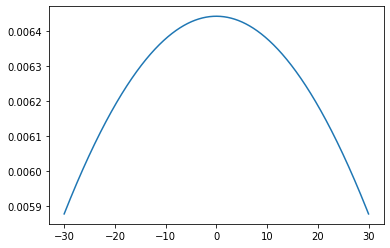

In [18]:
# Let's use the package:
from ldprofile_ctypes import QGaussianLDProfile

q35 = QGaussianLDProfile(3.0/5.0, 0.01)
z = np.linspace( -30.0, 30.0, 10000, dtype=np.float64 )
plt.plot( z, q35.evaluate(z) )

## Closing thoughts on using <tt>ctypes</tt> for a fully fledged OO interface
- It works!
- But: The whole OO API from C++ has to be duplicated
- Resource Management explicit (cf. `__del__`!) &rightarrow; no `RAII`
- We have to juggle a lot of untyped (void*) pointers around &rightarrow; difficult to debug
- If we want to keep the C++ and OO Python API similar, we have to keep 3 code-bases in sync &rightarrow; not scalable solution

<b>Note:</b>This approach is currently taken by <tt>SixTrackLib</tt> due to historic reasons. We are actively working on moving away from this implementation

# Alternative: Using <tt>pybind11</tt> + <tt>scikit-build</tt> 

<a href="https://github.com/pybind/pybind11">pybind11</a> provides seamless operability between C++11 and Python</a>

- Idea: write strongly typed wrapper code in C++ and use compile-time introspection to keep the amount of boilerplate code minimal
- relies in "modern" > C++11
- maps one type in C++ to one type in Python, i.e. generic code has to be specialized
- integrates well with scikit-build

In [21]:
os.chdir( initial_wd )
list_dir_tree( './02_ldprofile_pybind11', allow=["src", "ldprofile", "wrap", "examples", "cmake" ] )

02_ldprofile_pybind11/
    CMakeLists.txt
    setup.py
    pyproject.toml
    src/
        CMakeLists.txt
        wrap/
            CMakeLists.txt
            ldprofile_wrap.hpp
            ldprofile_wrap.cpp
            __init__.py
        ldprofile/
            qgauss.h
            base_profile.h
            CMakeLists.txt
            ld_lin_interpol.h
            base_profile.cpp
            ld_qgauss.cpp
            ld_coasting.h
            profile.cpp
            ldprofile.h
            ld_qgauss.h
            ld_lin_interpol.cpp
            definitions.h
            profile.h
            ld_coasting.cpp
            qgauss.cpp
    cmake/
        SetupPybind11.cmake
        SetupPybind11CMakeLists.txt.in
        Findpybind11.cmake
    examples/
        plot_profiles.py


The C++ core library is unchanged compared to the previous example. The bindings are provided by 

- `src/wrap/ldprofile_wrap.hpp` generic functions for setting up the bindings for the template types
- `src/wrap/ldprofile_wrap.cpp` defining the module, encoding the class relationship between the types, specialisation of the generic types
- `src/wrap/CMakeList.txt` build logic 



`src/wrap/ldprofile_wrap.cpp`:
    
```C++
#include "ldprofile_wrap.hpp"

namespace
{
    namespace py = pybind11;
    namespace ld = ldprofile;
    namespace ldpy = ldprofile::python;
}

PYBIND11_MODULE( ldprofile_pybind11, m )
{
    // m ... ldprofile_pybind11 module
    m.doc() = "ldprofile python bindings generated using pybind11";
    
    /* For double precision */
    using base_profile_t = ld::TLineDensityProfileBase< double >;
    using c_profile_t = ld::TCoastingLDProfile< double >;
    using q_profile_t = ld::QGaussianLDProfile< double >;
    using l_profile_t = ld::TLinInterpolLDProfile< double >;
    
    /* Model the class hierarchy */
    py::class_< base_profile_t > base_profile_obj( m, "LDProfileBase" );
    
    py::class_< c_profile_t > c_profile_obj( m, "CoastingLDProfile", base_profile_obj );
    py::class_< q_profile_t > q_profile_obj( m, "QGaussLDProfile", base_profile_obj );
    py::class_< l_profile_t > l_profile_obj( m, "LinInterpolLDProfile", base_profile_obj );
    
    /* call the binding generation functions for the specific types */
    ldpy::Create_bindings_base_profile< double >( m, base_profile_obj );
    ldpy::Create_bindings_coasting_profile< double >( m, c_profile_obj );
    ldpy::Create_bindings_qgauss_profile< double >( m, q_profile_obj );
    ldpy::Create_bindings_lin_interpol_profile< double >( m, l_profile_obj );
}
```

`src/wrap/ldprofile_wrap.hpp`:

```C++
#ifndef LDPROFILE_PYBIND11_LDPROFILE_WRAP_CXX_HPP__
#define LDPROFILE_PYBIND11_LDPROFILE_WRAP_CXX_HPP__

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>

#include <stdexcept>
#include <vector>
#include <iostream>

// NOTE: correct include path from target_link_libary with ldprofilecore
#include "ldprofile/ldprofile.h"

namespace ldprofile
{
namespace python
{
    template< class T >
    void Create_bindings_coasting_profile( pybind11::module& m,
        pybind11::class_< ldprofile::TCoastingLDProfile< T > >& cls )
    {
        namespace py = pybind11;
        namespace ld = ldprofile;

        using coasting_profile_t = ld::TCoastingLDProfile< T >;
        using value_t = typename coasting_profile_t::value_type;

        // Constructor -> we can define our own default arguments which
        // can differ from the defaults in C++!

        cls.def( py::init(
            []( value_t const& ld_value )
            {
                // use make_unique if available!
                return std::unique_ptr< coasting_profile_t >(
                    new coasting_profile_t( ld_value ) );
            } ),
            py::arg( "value" ) = value_t{ 42 } );
        
        // ...
    }
```

```C++
// ... 
//getter methods -> @property 
cls.def_property_readonly( "q", &qgauss_profile_t::q );
cls.def_property_readonly( "sqrt_beta", &qgauss_profile_t::sqrt_beta );
cls.def_property_readonly( "cq", &qgauss_profile_t::cq );
// ...
// Overloading methods by casting to the member function pointer (pre C++14 notation)
cls.def( "update", ( void ( qgauss_profile_t::* )( value_t const& )
             )&qgauss_profile_t::update,
         "update profile with a gaussian distribution",
         py::arg( "sigma" ) = 1.0 );

cls.def( "update", ( void ( qgauss_profile_t::* )(
             value_t const&, value_t const& ) )&qgauss_profile_t::update,
         "update profile with a q-gaussian distribution",
         py::arg( "q" ), py::arg( "sqrt_beta" ) );
```

```C++
// ...
// Overloading methods, version 2:

cls.def( "update",
    []( lin_profile_t& instance, value_t const& z0,
        value_t const& dz, size_t const num_values )
    {
        instance.update( z0, dz, num_values );
    },
    "updates the instance, changes the size to num_values and sets all values to 0",
    py::arg("z0"), py::arg( "dz" ), py::arg( "num_values" ) );

cls.def( "update",
    []( lin_profile_t& instance, value_t const& z0,
        value_t const& dz, py::buffer values )
    {
        py::buffer_info values_info = values.request();

        if( values_info.ndim != 1 )
            throw std::runtime_error( "values.ndim != 1" );

        instance.update( z0, dz,
            values_info.shape[ 0 ] * values_info.shape[ 1 ],
                 static_cast< value_t const* >( values_info.ptr ) );
    },
    "updates the instance, with new values; resizes as required",
    py::arg("z0") = value_t{ 0 },
    py::arg( "dz" ) = value_t{ 1 },
    py::arg( "values" ) = py::array_t< value_t >{} );

// ...
```

`src/wrap/CMakeLists.txt`

Not shown here for time reasons: pybind11 can be downloaded and setup during the configuration process by `cmake`. It is also rather light on dependencies (c++11 compiler required) -> very convenient! 

```CMake
if( NOT pybind11_FOUND )
    message( FATAL_ERROR "We positively need pybind11 for the bindings to work!" )
endif()

set( LDPROFILE_PYBIND11_HEADERS ldprofile_wrap.hpp )
set( LDPROFILE_PYBIND11_SOURCES ldprofile_wrap.cpp )

pybind11_add_module( ldprofile_pybind11 MODULE
    ${LDPROFILE_PYBIND11_HEADERS} ${LDPROFILE_PYBIND11_SOURCES} )

# include paths, definitions, etc. should be passed on transitiently from
# ldprofilecore:

target_link_libraries( ldprofile_pybind11 PRIVATE ldprofilecore )

file( COPY "${CMAKE_CURRENT_SOURCE_DIR}/__init__.py"
      DESTINATION ${CMAKE_CURRENT_BINARY_DIR} )

install( TARGETS ldprofile_pybind11 DESTINATION "ldprofile_pybind11" )
install( FILES __init__.py DESTINATION "ldprofile_pybind11" )
``` 

The `scikit-build` based `setup.py` file is very similar to the previous example:

```Python
from skbuild import setup
# ...

setup(
    name="ldprofile_pybind11",
    version="1.0.0",
    description="python bindings for ldprofile, using scikit-build and pybind11",
    author="Martin Schwinzerl",
    license="MIT",
    packages=['ldprofile_pybind11'],
    package_data={'ldprofile_pybind11': [_get_library_name("*")] },
    install_requires=['numpy'],
    #cmake_args=['-DCMAKE_BUILD_TYPE=Debug',]
)
``` 

and complements the minimal `__init__.py` from the `src/wrap` directory:

```Python
from .ldprofile_pybind11 import CoastingLDProfile, QGaussianLDProfile, LinInterpolLDProfile
```

In [38]:
# Let's build the pybind11 based project:

os.chdir( initial_wd )
os.chdir( '02_ldprofile_pybind11')
%run setup.py build


copying /home/martin/git/pyhep2020-cxx-bindings/02_ldprofile_pybind11/ldprofile_pybind11/ldprofile_pybind11.cpython-38-x86_64-linux-gnu.so -> _skbuild/linux-x86_64-3.8/cmake-install/ldprofile_pybind11/ldprofile_pybind11.cpython-38-x86_64-linux-gnu.so

running build
running build_py
copying _skbuild/linux-x86_64-3.8/cmake-install/ldprofile_pybind11/ldprofile_pybind11.cpython-38-x86_64-linux-gnu.so -> _skbuild/linux-x86_64-3.8/setuptools/lib/ldprofile_pybind11
copied 1 files
running build_ext


In [39]:
%run setup.py install


copying /home/martin/git/pyhep2020-cxx-bindings/02_ldprofile_pybind11/ldprofile_pybind11/ldprofile_pybind11.cpython-38-x86_64-linux-gnu.so -> _skbuild/linux-x86_64-3.8/cmake-install/ldprofile_pybind11/ldprofile_pybind11.cpython-38-x86_64-linux-gnu.so

running install
running bdist_egg
running egg_info
writing ldprofile_pybind11.egg-info/PKG-INFO
writing dependency_links to ldprofile_pybind11.egg-info/dependency_links.txt
writing requirements to ldprofile_pybind11.egg-info/requires.txt
writing top-level names to ldprofile_pybind11.egg-info/top_level.txt
reading manifest file 'ldprofile_pybind11.egg-info/SOURCES.txt'
writing manifest file 'ldprofile_pybind11.egg-info/SOURCES.txt'
installing library code to _skbuild/linux-x86_64-3.8/setuptools/bdist.linux-x86_64/egg
running install_lib
running build_py
copying _skbuild/linux-x86_64-3.8/cmake-install/ldprofile_pybind11/ldprofile_pybind11.cpython-38-x86_64-linux-gnu.so -> _skbuild/linux-x86_64-3.8/setuptools/lib/ldprofile_pybind11
copied 1

# Example usage of the pybind11 generated bindings

In [40]:
os.chdir( initial_wd )
import ldprofile_pybind11 as ldp

In [41]:
q1 = ldp.QGaussianLDProfile(1.0)
?q1.evaluate

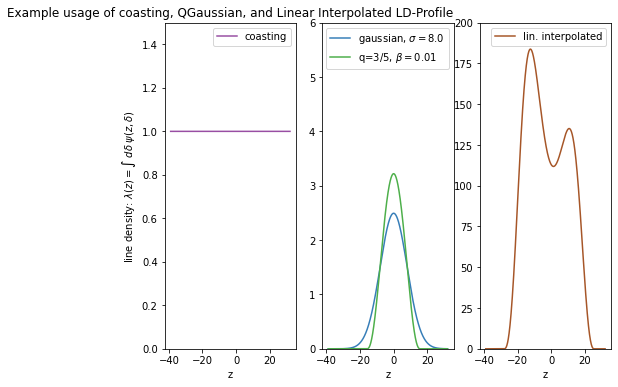

In [47]:
%run 02_ldprofile_pybind11/examples/plot_profiles.py

## Summary of using <tt>pybind11</tt> for a fully fledged OO interface
- Interfacing is done on the C/C++ side &rightarrow; retain strongly typed information, const-ness, etc.
- Can be easily integrated with existing C++ projects
- Very light on dependencies, little restrictions on compiler and external libraries
- Compilation can take time and resources -> splitting into submodules and performing the specialization in separate translation units
- Good integration with numpy, buffer protocoll, etc.
- Most of the instructions in the bindings creation functions can be autogenerated from a suitable reflection file (if the API has been designed with such a use-case in mind!)
- Resulting module library can be quite large &rightarrow; LTO, Optimization, only use the symbols that are really needed